In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import SGD, Adam
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
data_dir = "./data/"


mnist_train_set = datasets.MNIST(data_dir + 'mnist/', train = True, download = True)
mnist_test_set = datasets.MNIST(data_dir + 'mnist/', train = False, download = True)

mnist_train_input = mnist_train_set.data.view(-1, 1, 28, 28).float()
mnist_train_target = mnist_train_set.targets
mnist_test_input = mnist_test_set.data.view(-1, 1, 28, 28).float()
mnist_test_target = mnist_test_set.targets


fashion_mnist_train_set = datasets.FashionMNIST(data_dir + 'fashion_mnist/', train = True, download = True)
fashion_mnist_test_set = datasets.FashionMNIST(data_dir + 'fashion_mnist/', train = False, download = True)

fashion_mnist_train_input = fashion_mnist_train_set.data.view(-1, 1, 28, 28).float()
fashion_mnist_train_target = fashion_mnist_train_set.targets
fashion_mnist_test_input = fashion_mnist_test_set.data.view(-1, 1, 28, 28).float()
fashion_mnist_test_target = fashion_mnist_test_set.targets

In [4]:
def standardize_data(train_input, test_input):
    mean, std = train_input.mean(), train_input.std()
    
    return (train_input - mean) / std, (test_input - mean) / std

In [5]:
class MnistClassifier(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.maxp1 = nn.MaxPool2d(kernel_size=2)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4)
        self.maxp2 = nn.MaxPool2d(kernel_size=2)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=256)
        self.bn4 = nn.BatchNorm1d(num_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
    def forward(self, x):
        y = self.bn1(F.relu(self.maxp1(self.conv1(x))))
        y = self.bn2(F.relu(self.maxp2(self.conv2(y))))
        y = self.bn3(F.relu(self.conv3(y).view(-1, 64)))
        y = self.bn4(F.relu(self.fc1(y)))
        y = F.relu(self.fc2(y))
        return y

In [6]:
def deep_model_param_loss_gradients_to_flat_vector(model_params):
    return torch.cat([param.grad.view(-1).cpu() for param in model_params])

In [7]:
def train_model(model, train_input, train_target, num_epochs=25, lr=1e-1, mini_batch_size=6000, adam=False):
    if adam:
        optimizer = Adam(model.parameters(), lr=lr)
    else:
        optimizer = SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().cuda()
    num_samples = train_input.size(0)
    loss_gradients_series=[]
    for e in range(1, num_epochs+1):
        sum_loss=0
        for b in range(0, num_samples, mini_batch_size):
            train_input_mini_batch = train_input[b:min(b+mini_batch_size, num_samples)]
            train_target_mini_batch = train_target[b:min(b+mini_batch_size, num_samples)]
            optimizer.zero_grad()
            prediction_mini_batch = model(train_input_mini_batch)
            loss = criterion(prediction_mini_batch, train_target_mini_batch)
            sum_loss += loss.item()
            loss.backward()
            with torch.no_grad():
                loss_gradients = deep_model_param_loss_gradients_to_flat_vector(model.parameters())
                loss_gradients_series.append(loss_gradients)
            optimizer.step()
            torch.cuda.empty_cache()
        print("Epoch {} Loss: {}".format(e, sum_loss))
    loss_gradients_series = torch.stack(loss_gradients_series)
    return model, loss_gradients_series

In [8]:
def test_model(model, test_input, test_target):
    model.train(False)
    prediction = model(test_input)
    predicted_labels = torch.argmax(prediction, dim=1)
    accuracy = (predicted_labels == test_target).float().mean().item()
    return accuracy

In [9]:
def estimate_convergence_threshold_phlug_diagnostic(loss_gradients_series, burn_in=1):
    num_sgd_iterations_performed = len(loss_gradients_series)
    s_series = [0, ]
    convergence_threshold_set=False
    convergence_threshold = np.inf
    for n in range(1, num_sgd_iterations_performed):
        s_n = s_series[n-1] + torch.dot(loss_gradients_series[n], loss_gradients_series[n-1]).item()
        s_series.append(s_n)
        if not convergence_threshold_set and n > burn_in and s_n < 0:
            convergence_threshold = n
            convergence_threshold_set = True
    s_series = np.array(s_series)
    return convergence_threshold, s_series

In [10]:
mnist_train_input, mnist_test_input = standardize_data(mnist_train_input, mnist_test_input)
mnist_train_input = mnist_train_input.cuda()
mnist_train_target = mnist_train_target.cuda()
mnist_test_input = mnist_test_input.cuda()
mnist_test_target = mnist_test_target.cuda()

In [27]:
mnist_model, mnist_training_loss_grads = train_model(MnistClassifier().cuda(),
                                                     mnist_train_input,
                                                     mnist_train_target,
                                                    lr=0.25,
                                                    num_epochs=25,
                                                    mini_batch_size=6000)

Epoch 1 Loss: 6.9197405725717545
Epoch 2 Loss: 1.3246608451008797
Epoch 3 Loss: 0.8873720690608025
Epoch 4 Loss: 0.6905576176941395
Epoch 5 Loss: 0.5722537711262703
Epoch 6 Loss: 0.4896736443042755
Epoch 7 Loss: 0.428383432328701
Epoch 8 Loss: 0.3798716217279434
Epoch 9 Loss: 0.3401841018348932
Epoch 10 Loss: 0.30656355060636997
Epoch 11 Loss: 0.2776620648801327
Epoch 12 Loss: 0.25281232967972755
Epoch 13 Loss: 0.2307110521942377
Epoch 14 Loss: 0.211116511374712
Epoch 15 Loss: 0.19323517009615898
Epoch 16 Loss: 0.17733860667794943
Epoch 17 Loss: 0.1628881311044097
Epoch 18 Loss: 0.14987487066537142
Epoch 19 Loss: 0.13843884598463774
Epoch 20 Loss: 0.12787540070712566
Epoch 21 Loss: 0.11804241314530373
Epoch 22 Loss: 0.10930366441607475
Epoch 23 Loss: 0.10122969374060631
Epoch 24 Loss: 0.09401006810367107
Epoch 25 Loss: 0.08753834338858724


In [28]:
test_model(mnist_model, mnist_test_input, mnist_test_target)

0.9887999892234802

In [29]:
mnist_conv_thresh, mnist_s_series = estimate_convergence_threshold_phlug_diagnostic(mnist_training_loss_grads,
                                                                                    burn_in=10)
mnist_conv_thresh

11

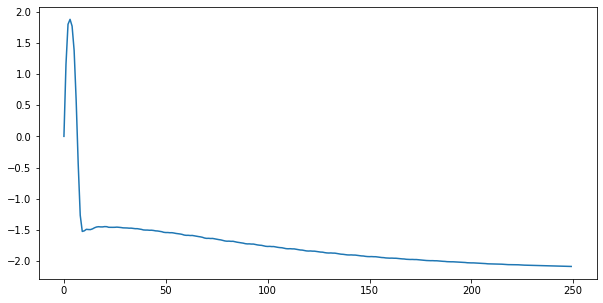

In [30]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=mnist_s_series)
plt.show()

In [10]:
class SgdToHalf(torch.optim.Optimizer):
    def __init__(self, params, lr, burn_in=1):
        self.params = params
        self.lr = lr
        self.burn_in = burn_in
        self.n = 1
        self.s = 0
        self.tau = 0
        self.prev_grad = None
        defaults = {"lr": lr, "burn_in": burn_in, "n": 1, "s": 0, "tau": 0, "prev_grad": None}
        super(SgdToHalf, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SgdToHalf, self).__setstate__(state)
        
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        group = self.param_groups[0]
        lr = group["lr"]
        burn_in = group["burn_in"]
        n = group["n"]
        s = group["s"]
        tau = group["tau"]
        
        params = group["params"]
        for p in params:
            if p.grad is None:
                continue
            g_p = p.grad
            p.add_(g_p, alpha=-lr)
        
        g = deep_model_param_loss_gradients_to_flat_vector(params)
        if n == 1:
            self.prev_grad = group["prev_grad"] = torch.clone(g).detach()
        else:
            g_prev = group["prev_grad"]
            s += torch.dot(g.view(-1), g_prev.view(-1))
            if n > (tau + burn_in) and s < 0:
                self.tau = group["tau"] = n
                s = 0
                self.lr = group["lr"] = lr / 2
            self.s = group["s"] = s
            self.prev_grad = group["prev_grad"] = torch.clone(g).detach()
            
        self.n = group["n"] = n+1
                
        return loss

    def converged(self):
        return self.n > (self.tau + self.burn_in) and self.s < 0 and self.lr < 1e-10

In [45]:
fashion_mnist_train_input, fashion_mnist_test_input = standardize_data(fashion_mnist_train_input, fashion_mnist_test_input)
fashion_mnist_train_input = fashion_mnist_train_input.cuda()
fashion_mnist_train_target = fashion_mnist_train_target.cuda()
fashion_mnist_test_input = fashion_mnist_test_input.cuda()
fashion_mnist_test_target = fashion_mnist_test_target.cuda()
fashion_mnist_model, fashion_mnist_training_loss_grads = train_model(MnistClassifier().cuda(),
                                                                     fashion_mnist_train_input,
                                                                     fashion_mnist_train_target, lr=0.05)

Epoch 1 Loss: 13.286364436149597
Epoch 2 Loss: 6.921902656555176
Epoch 3 Loss: 5.573513209819794
Epoch 4 Loss: 4.862002283334732
Epoch 5 Loss: 4.4032759964466095
Epoch 6 Loss: 4.0768440663814545
Epoch 7 Loss: 3.850387156009674
Epoch 8 Loss: 3.6797103583812714
Epoch 9 Loss: 3.5291371047496796
Epoch 10 Loss: 3.3769662380218506
Epoch 11 Loss: 3.2996226251125336
Epoch 12 Loss: 3.2142632007598877
Epoch 13 Loss: 3.09516841173172
Epoch 14 Loss: 3.0241662561893463
Epoch 15 Loss: 2.975294589996338
Epoch 16 Loss: 2.883358806371689
Epoch 17 Loss: 2.8433918952941895
Epoch 18 Loss: 2.7980430126190186
Epoch 19 Loss: 2.720885992050171
Epoch 20 Loss: 2.6864026486873627
Epoch 21 Loss: 2.63807013630867
Epoch 22 Loss: 2.6077900826931
Epoch 23 Loss: 2.5481671690940857
Epoch 24 Loss: 2.494541674852371
Epoch 25 Loss: 2.4783617854118347


In [46]:
test_model(fashion_mnist_model, fashion_mnist_test_input, fashion_mnist_test_target)

0.8833999633789062

In [47]:
fashion_mnist_conv_thresh, fashion_mnist_s_series = estimate_convergence_threshold_phlug_diagnostic(fashion_mnist_training_loss_grads,
                                                                                                    burn_in=10)
fashion_mnist_conv_thresh

101

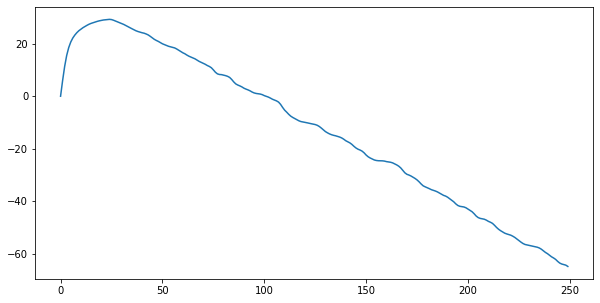

In [48]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fashion_mnist_s_series)
plt.show()